# 1. Importing Dependancies

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import itertools
import datetime
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import altair as alt
import altair_latimes as lat
from shapely.geometry import Point, Polygon
import geopandas as gpd
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

params = {'legend.fontsize': '20',
          'figure.figsize': (15, 5),
         'axes.labelsize': '18',
         'axes.titlesize':'30',
         'xtick.labelsize':'16',
         'ytick.labelsize':'16'}
plt.rcParams.update(params)

plt.rcParams['text.color'] = '#A04000'
plt.rcParams['xtick.color'] = '#800000'
plt.rcParams['ytick.color'] = '#808000'
plt.rcParams['axes.labelcolor'] = '#283747'

class color:

    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# 2. Data Preprocessing

In [22]:
df = pd.read_csv('la_crime_v2.csv')

init_colnames = list(df.columns)
df.rename(columns = {  'DR_NO':'record_id', 'Date Rptd':'date_reported', 'DATE OCC':'date_occurred', 'TIME OCC':'time_occurred', 'AREA ':'division','AREA NAME':'division_name',
'Rpt Dist No':'reporting_district', 'Part 1-2':'part_type', 'Crm Cd':'crime_code','Crm Cd Desc':'crime_code_description',
'Mocodes':'modus_operandi_code', 'Vict Age':'victim_age', 'Vict Sex':'victim_sex','Vict Descent':'victim_descent',
'Premis Cd':'premises_code', 'Premis Desc':'premises_description','Weapon Used Cd':'weapon_code','Weapon Desc':'weapon_description',
'Status':'status_code','Status Desc':'status_code_description','Crm Cd 1':'crm_cd_1','Crm Cd 2':'crm_cd_2',
'Crm Cd 3':'crm_cd_3','Crm Cd 4':'crm_cd_4','LOCATION':'address','Cross Street':'cross_street','LAT':'latitude','LON':'longitude'}, inplace = True)

df['date_reported'] = df['date_reported'].str.replace(' 0:00','')
df['date_occurred'] = df['date_occurred'].str.replace(' 0:00','')

df['date_reported'] = pd.to_datetime(df['date_reported'], format='%m/%d/%Y')
df['date_occurred'] = pd.to_datetime(df['date_occurred'], format='%m/%d/%Y')
df['year'] = df['date_occurred'].dt.year
df['quarter'] = df['date_occurred'].dt.quarter
df['day'] = df['date_occurred'].dt.day
df['month'] = df['date_occurred'].dt.month
df['weekday'] = df['date_occurred'].dt.weekday
df['monthname'] = df['date_occurred'].dt.month_name()

descent_recode = { 'A':"asian",'B':"black",'C':"asian",'D':"asian",'F':"asian",'G':"asian",\
                 'H':"hispanic",'I':"asian",'J':"asian",\
                 'K':"asian",'L':"asian",'O':"other",'P':"asian",'S':"asian",\
                 'U':"asian",'V':"asian",'W':"white",'X':"other",'Z':"asian" }

df['descent_description'] = df['victim_descent'].map(descent_recode)

victim_sex_recode = { 'F':"female",'M':"male",'X':"unknown",'-':"unknown",'N':"unknown",'H':"unknown" }

df['victim_sex'] = df['victim_sex'].map(victim_sex_recode)

df['premises_code'] = df['premises_code'].astype(str).str.replace('.0','', regex=False)
df['premises_code'] = df['premises_code'].astype(str).str.replace('.0','', regex=False)
df['crm_cd_1'] = df['crm_cd_1'].astype(str).str.replace('.0','', regex=False)
df['crm_cd_2'] = df['crm_cd_2'].astype(str).str.replace('.0','', regex=False)

df['premises_description'] = df['premises_description'].str.capitalize()
df['status_code_description'] = df['status_code_description'].str.lower().str.replace(' ','_')
df['crime_code_description'] = df['crime_code_description'].str.capitalize()
df['weapon_description'] = df['weapon_description'].str.capitalize()

monthnames = ['January','February','March','April','May','June','July','August','September','October','November','December']

df['time_occurred'] = df['time_occurred'].astype(str).str.replace('.0','', regex=False)
df['time_occurred'] = df['time_occurred'].astype(str).str.zfill(4)
df['hour'] = df['time_occurred'].astype(str).str[:2]
df['minute'] = df['time_occurred'].astype(str).str[2:]
df = df[df['hour'] != '0n']
df = df[df['hour'] != '24']

df['part_type'] = df['part_type'].astype(str).str.replace('.0', '', regex=False)

df['reporting_district'] = df['reporting_district'].astype(str).str.replace('.0', '', regex=False)

descent_recode = { 'A':"asian",'B':"black",'C':"asian",'D':"asian",'F':"asian",'G':"asian",\
                 'H':"hispanic",'I':"asian",'J':"asian",\
                 'K':"asian",'L':"asian",'O':"other",'P':"asian",'S':"asian",\
                 'U':"asian",'V':"asian",'W':"white",'X':"other",'Z':"asian" ,'nan': 'other'}

df['victim_sex'].fillna('unknown',inplace = True)
df['victim_descent'].fillna('X',inplace = True)
df['victim_descent'] = df['victim_descent'].apply(lambda j: descent_recode[j]) 
df['premises_description'].fillna('Other premise', inplace = True)
df = df[df['victim_sex'].isin(['female','male'])]

bins= [0,4,13,20,50, 110]
labels = ['Toddler','Kid','Teen','Adult', 'Elder']
df['AgeGroup'] = pd.cut(df['victim_age'], bins=bins, labels=labels, right=False)

# 3. Exploratory Data Analysis

## 3.1 Top Crimes

In [19]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(columnNames[i])
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
# Correlation matrix
def plotCorrelationMatrix(df, graphheight, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphheight), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Correlation Matrix', fontsize=15)
    plt.show()
    
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
    

### 3.1.1 Divisoin Name

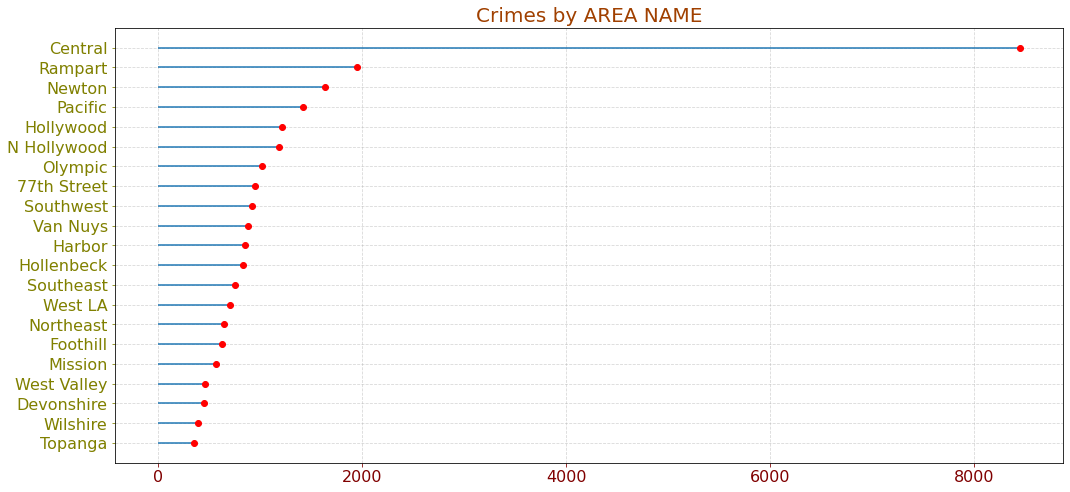

In [20]:
dfmap = (df.groupby(["date_occurred", "address", "latitude", "longitude"])["division_name"].sum()).reset_index()
dfmap['division_name'] = df['division_name'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')
dfmap_gpb = dfmap.groupby(['division_name'])["division_name", "latitude", "longitude"].size().reset_index(name='count')

fig, ax = plt.subplots(figsize = (17,8))
dfmap_gpb = dfmap_gpb.sort_values(by = 'count', axis=0, ascending = True).reset_index(drop = True)

ax.hlines(dfmap_gpb['division_name'], xmin=0, xmax=dfmap_gpb['count'])
ax.plot(dfmap_gpb['count'], dfmap_gpb['division_name'], "o", color='red')
    
# Decorate
plt.title('Crimes by AREA NAME', fontdict={'size':20});
plt.grid(linestyle='--', alpha=0.5);

plt.show();

### 3.1.2 Age Group

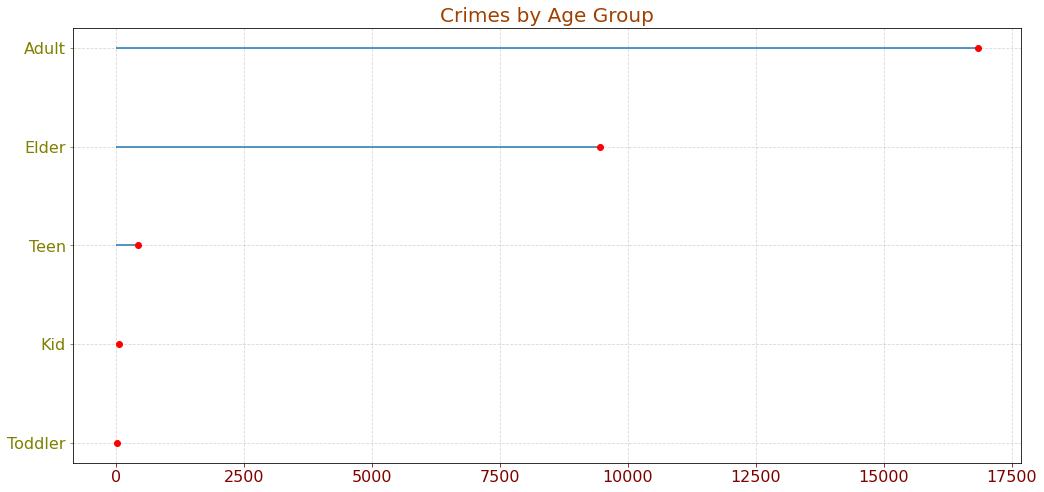

In [21]:
dfmap_gpb= df.groupby('AgeGroup').count().reset_index().iloc[:,0:2].rename(columns = {'record_id': 'count'})
fig, ax = plt.subplots(figsize = (17,8))
dfmap_gpb = dfmap_gpb.sort_values(by = 'count', axis=0, ascending = True).reset_index(drop = True)

ax.hlines(dfmap_gpb['AgeGroup'], xmin=0, xmax=dfmap_gpb['count'])
ax.plot(dfmap_gpb['count'], dfmap_gpb['AgeGroup'], "o", color='red')
    
# Decorate
plt.title('Crimes by Age Group', fontdict={'size':20});
plt.grid(linestyle='--', alpha=0.5);

plt.show();

## 3.2. Correlation Plots

### 3.2.1 Categorical Data

<AxesSubplot:>

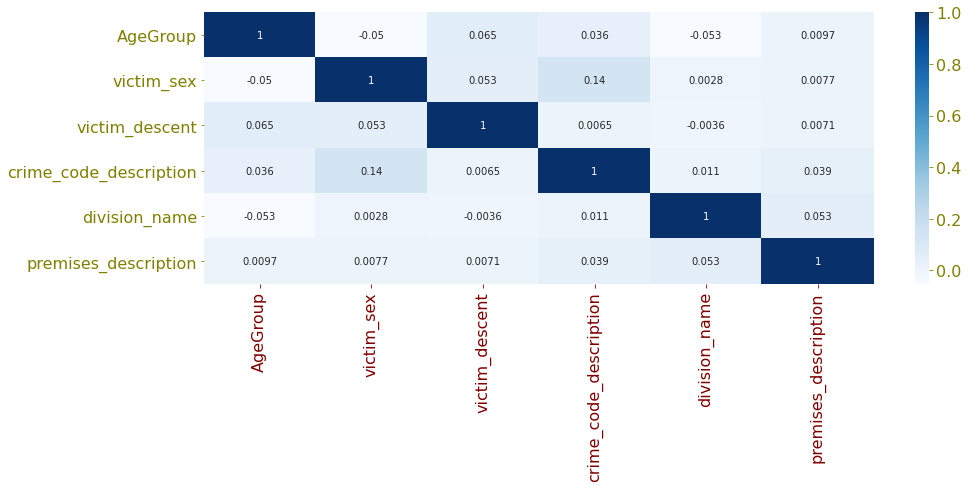

In [72]:
categorical_df = df.copy()
categorical_df = categorical_df[['AgeGroup','victim_sex','victim_descent','crime_code_description','division_name','premises_description']]
for i, c in enumerate(categorical_df):
    categorical_df[c] = pd.factorize(categorical_df[c])[0]
sns.heatmap(categorical_df.corr(),annot = True, cmap = 'Blues')

## 3.2.2 Continuous Data

<AxesSubplot:>

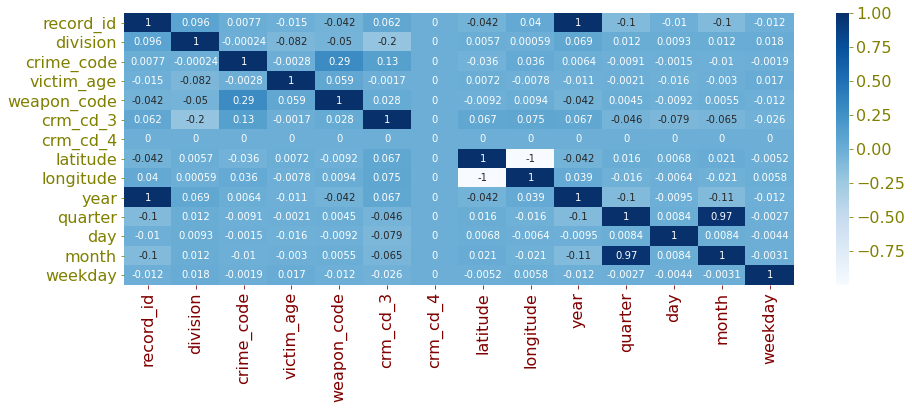

In [59]:
sns.heatmap(df.corr().fillna(0), annot = True, cmap = 'Blues')

## 3.3. Pair Plot

### 3.3.1 Categorical Data

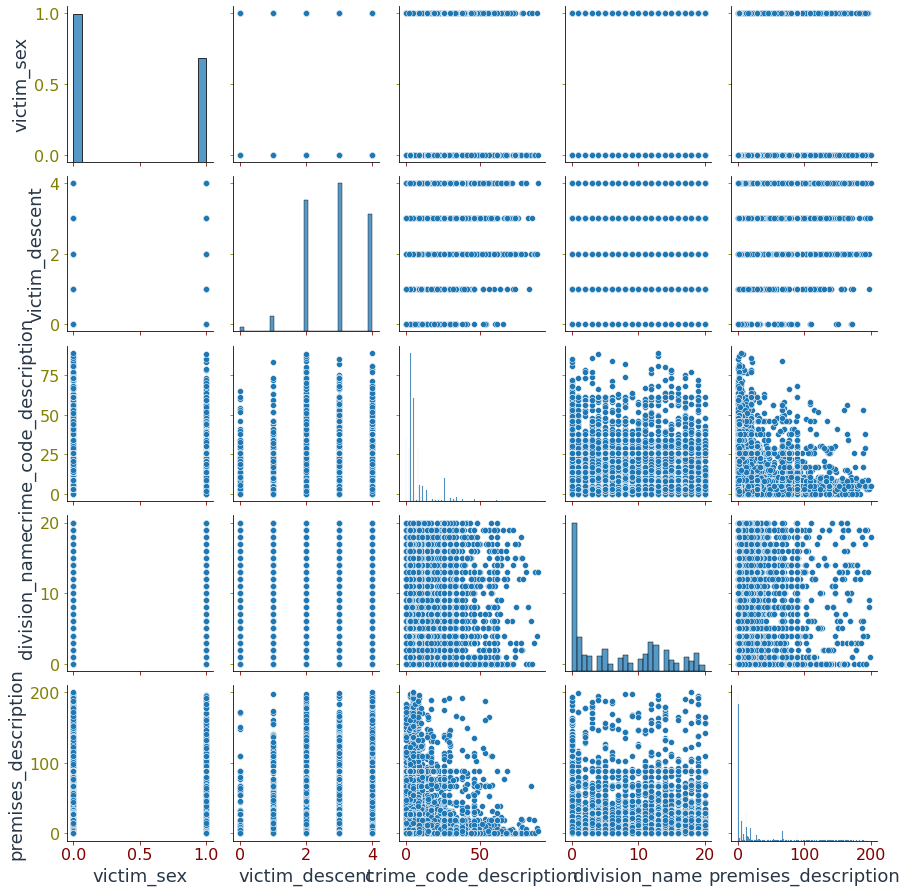

In [69]:
plot = sns.pairplot(categorical_df);
plt.tight_layout();

### 3.3.2 Continuous Data

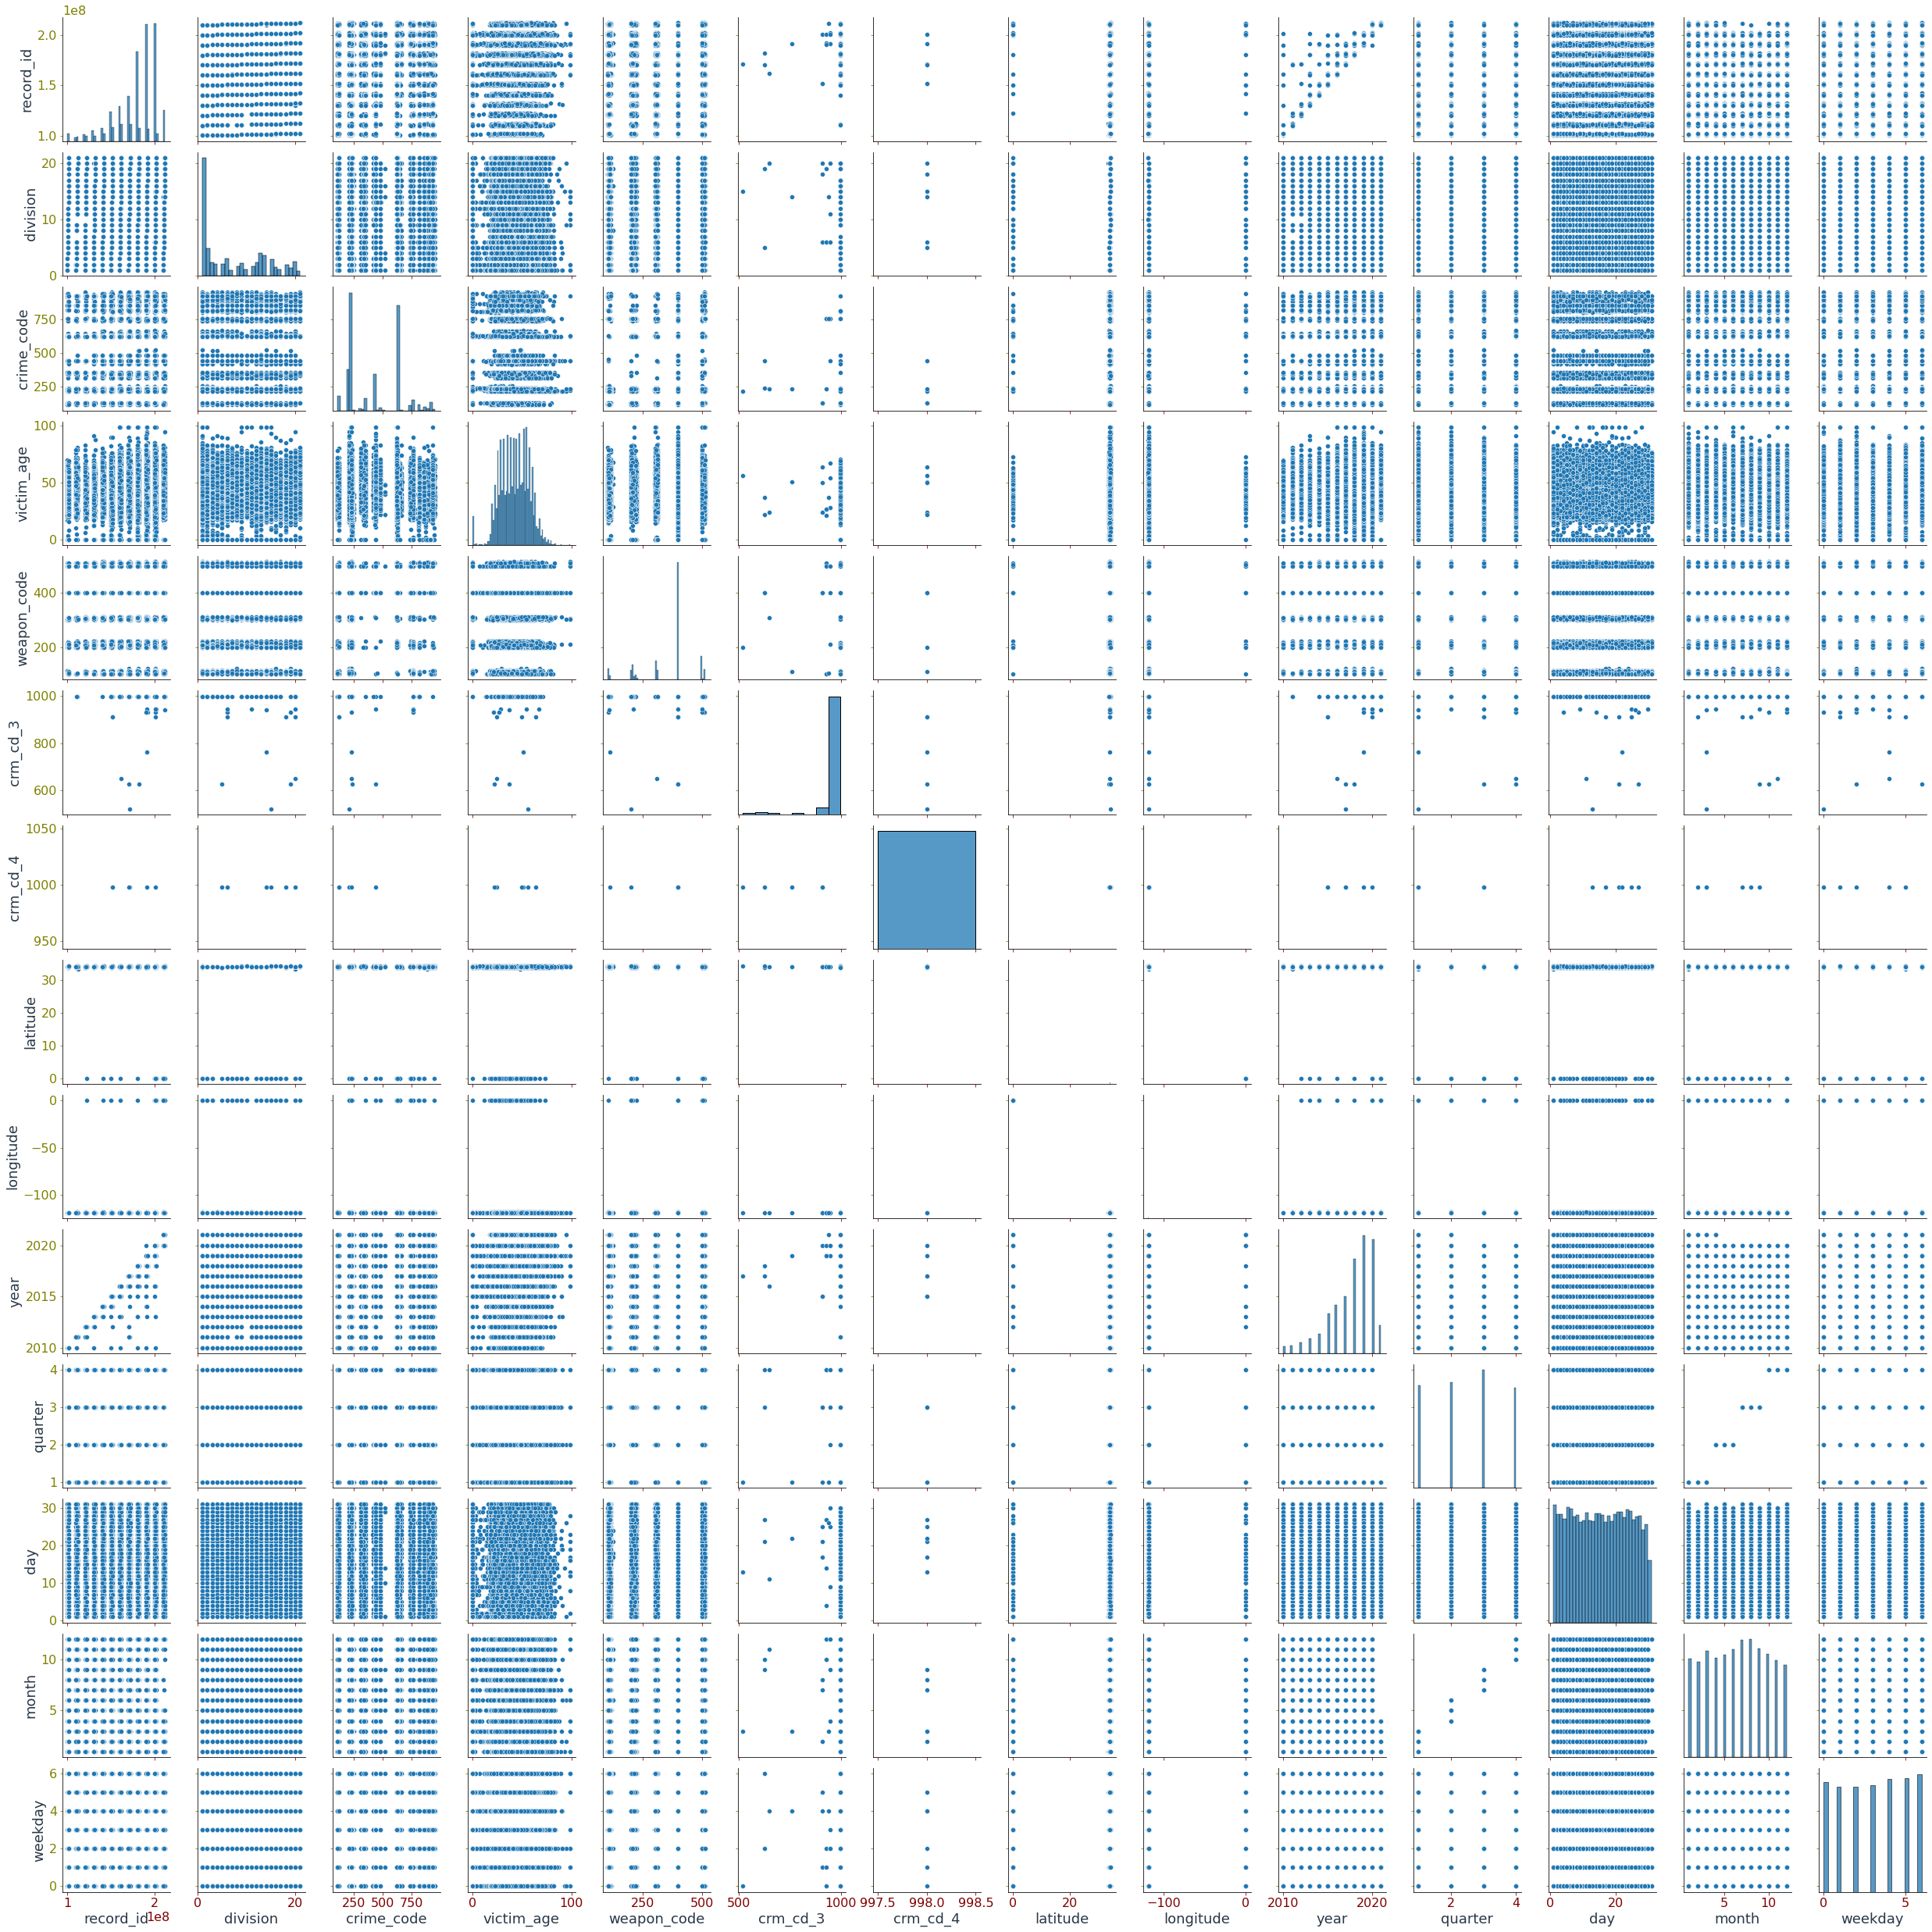

In [61]:
sns.pairplot(df);

## 3.4. Maps

In [24]:
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]

df['geometry'] = geometry

crs = {'init': 'epsg:4326'}

df_locs = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

city_bound = gpd.read_file("tl_2018_06037_roads.shp")

top_5_crimes = df_locs.groupby(['crime_code_description']).count().\
rename(columns = {'record_id': 'total'}).sort_values(by='total', ascending=False).index.tolist()[:5]

top_5_divisions = df_locs.groupby(['division_name']).count().\
rename(columns = {'record_id': 'total'}).sort_values(by='total', ascending=False).index.tolist()[:5]

values_dict = {
    'victim_sex': df_locs['victim_sex'].unique().tolist(),
    'victim_descent': df_locs['victim_descent'].unique().tolist(),
    'AgeGroup': df_locs['AgeGroup'].unique().tolist(),
    'crime_code_description': top_5_crimes,
    'division_name': top_5_divisions
              }

In [13]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


for key,values in list ( values_dict.items() )[:]:

    fig, ax = plt.subplots(figsize = (25,25));
    plt.title("Los Angeles By "+key);

    city_bound.plot(color='grey', ax=ax, alpha = 0.2);
    
    color_counter = 0
    
    for value in values[:]:
        
        print(key, value)

        time_series_df [time_series_df[key] == value  ] ['geometry'].plot(marker='o', color=colors[color_counter], markersize=2, ax=ax, label = value.upper());
        
        color_counter += 1
    
    plt.ylim([33.65, 34.35]);
    plt.legend(loc = 'upper left',prop={'size': 15});
    plt.tight_layout();
    plt.show();

# 4. Modelling

## 4.1. K means & PAM Clustering

### 4.1.1 Data Preprocessing

In [73]:
homeless_crimes_all = df.copy()
homeless_crimes_all.drop_duplicates(inplace=True)
homeless_crimes_all = homeless_crimes_all.reset_index(drop = True)
homeless_crimes_all.drop(['date_reported','date_occurred','time_occurred','modus_operandi_code', 'reporting_district'],axis =1,inplace = True)
clusteringDF = homeless_crimes_all.copy()
cols = ['AgeGroup','victim_sex','victim_descent','record_id', 'crime_code', 'premises_code', 'weapon_code', 'crm_cd_1', 'crm_cd_2', 'crm_cd_3', 'crm_cd_4',
        'division', 'division_name', 'crime_code_description', 'premises_description', 'weapon_description', 'descent_description',
        'address', 'cross_street', 'latitude','longitude', 'monthname', 'year']
clustering_metadata = clusteringDF[cols]

cols = ['record_id', 'crime_code', 'premises_code', 'weapon_code', 'crm_cd_1', 'crm_cd_2', 'crm_cd_3', 'crm_cd_4',
        'division', 'crime_code_description', 'premises_description', 'weapon_description',
        'address', 'cross_street', 'latitude','longitude', 'monthname', 'year']

clusteringDF.drop(cols, axis = 1 ,inplace=True)

dummies_cols = ['division_name', 'part_type', 'AgeGroup','victim_sex', 'victim_descent', 'status_code', 'status_code_description',
               'descent_description']


dummies = pd.get_dummies(clusteringDF[dummies_cols])
clusteringDF = pd.concat([clusteringDF, dummies], axis=1)
clusteringDF.drop(dummies_cols, axis = 1, inplace = True)

clusteringDF['hour'] = clusteringDF['hour'].astype(int)

clusteringDF['minute'] = clusteringDF['minute'].astype(int)

clusteringDF.replace([np.inf, -np.inf], np.nan, inplace=True)
clusteringDF_noNAs = clusteringDF.dropna()

### 4.1.2. Find Optimal Number Of Cluster

#### Elbow Method

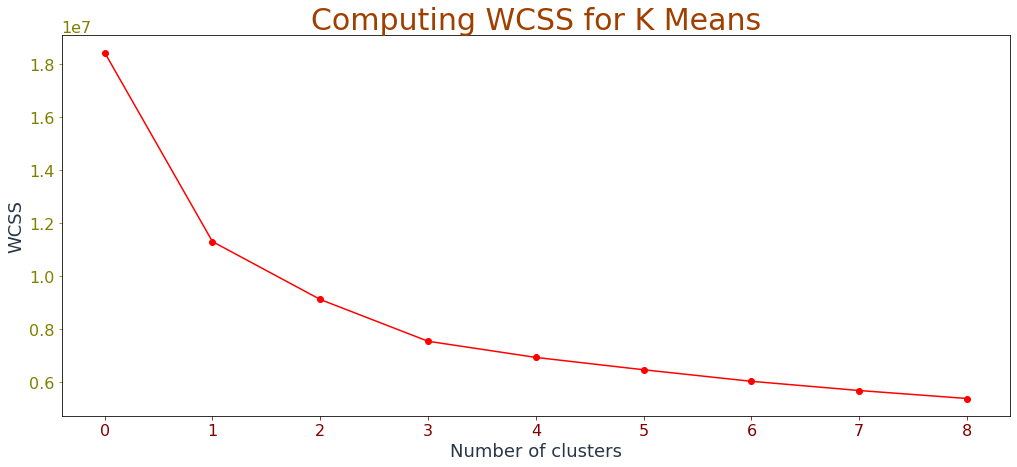

In [74]:
from sklearn.cluster import KMeans;
import sklearn
vals = clusteringDF_noNAs;

wcss = [];
for n in range(1, 10):
    classifier = KMeans(n_clusters=n, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')
    classifier.fit_predict( vals );
    wcss.append( classifier.inertia_ );
    
plt.figure(figsize = (17,7))
plt.plot( wcss, 'ro-', label="WCSS");
plt.title("Computing WCSS for K Means");
plt.xlabel("Number of clusters");
plt.ylabel("WCSS");
plt.show();

So the optimal number of clusters is **2**

#### Silhoutte Score

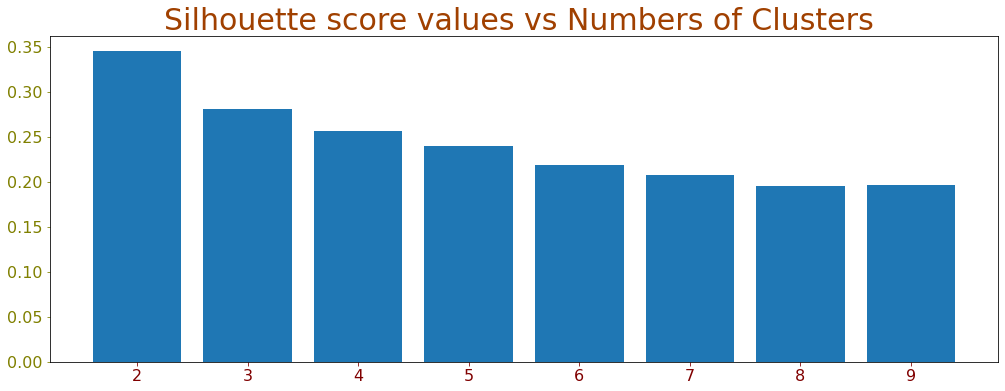

Optimal number of clusters is: 2


In [75]:
#declare empty list to store silhouette_score

silhouette_score_values=list()

# Select feature variable
# Initialize how many cluster

NumberOfClusters=range(2,10)

# Initialize for loop to calculate silhouette_score for each #cluster

for i in NumberOfClusters:
    classifier=KMeans(i, n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True);
    classifier.fit(clusteringDF_noNAs.values);
    labels= classifier.predict(clusteringDF_noNAs.values);
    silhoutte_score = sklearn.metrics.silhouette_score(clusteringDF_noNAs.values,labels ,metric='euclidean', sample_size=None, random_state=None);
    silhouette_score_values.append(silhoutte_score);
    #plot the NumberOfClusters, silhouette_score_values

plt.figure(figsize = (17,6));
plt.bar(NumberOfClusters, silhouette_score_values);
plt.title("Silhouette score values vs Numbers of Clusters ");
plt.show();

# find optimal number of clusters

Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print ("Optimal number of clusters is:" ,Optimal_NumberOf_Components);

### 4.1.3 K Means & PAM Modeling

In [76]:
# Import KMEANS
from sklearn.cluster import KMeans
# Import PAM
from sklearn_extra.cluster import KMedoids

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto');

pam = KMedoids(n_clusters=2, metric='euclidean', method='pam', init='heuristic', max_iter=500, random_state=None);

print("Training KMeans ...")
kmeans.fit(clusteringDF);
kmeans_preds = kmeans.predict(clusteringDF);

print("Training PAM ...")
pam.fit(clusteringDF);
kmediods_preds = pam.predict(clusteringDF);

clusteringDF['Kmeans_labels'] = kmeans_preds
clusteringDF['PAM_labels'] = kmediods_preds

clusteringDF = pd.concat([clusteringDF, clustering_metadata], axis = 1);

Training KMeans ...
Training PAM ...


### 4.1.4 Data Visualization

####  K Means: Age vs Sex

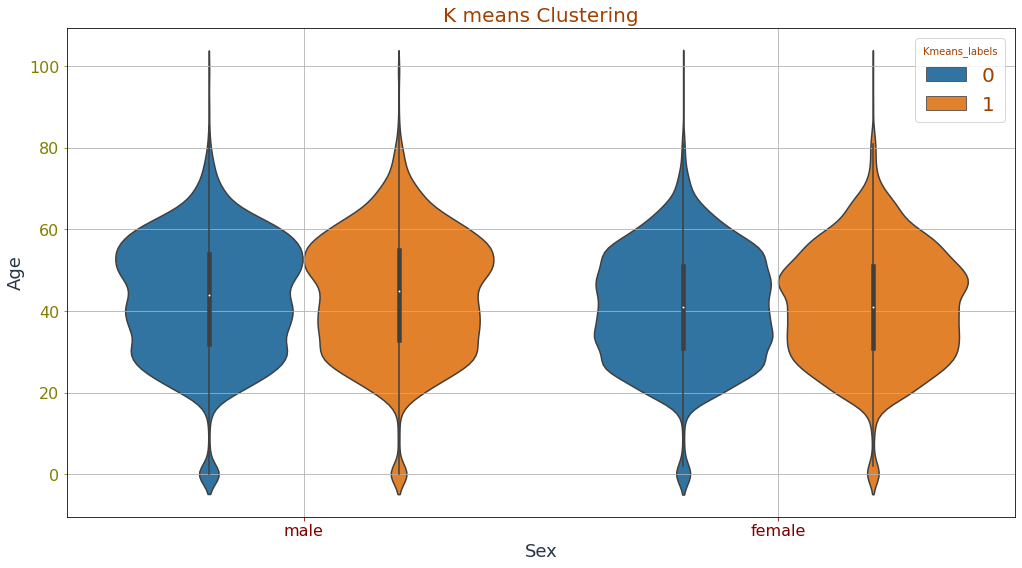

In [77]:
plt.figure(figsize = (17,9))

sns.violinplot(x='victim_sex',y='victim_age',hue = 'Kmeans_labels',data= clusteringDF)

plt.xlabel('Sex')
plt.ylabel('Age')
plt.title('K means Clustering', fontsize = 20);

plt.grid();
plt.show();

####  PAM: Age vs Sex

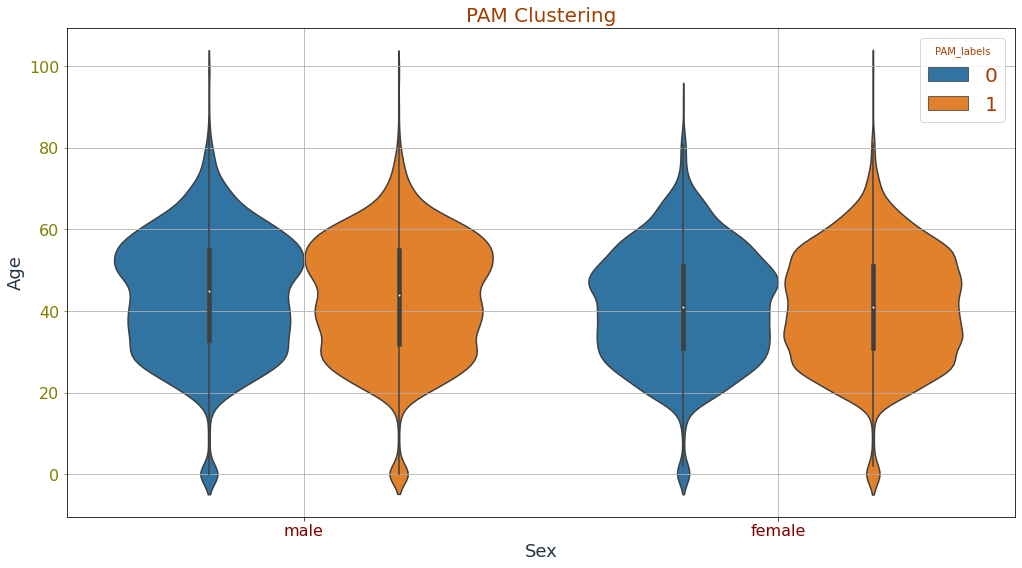

In [78]:
plt.figure(figsize = (17,9))

sns.violinplot(x='victim_sex',y='victim_age',hue = 'PAM_labels',data= clusteringDF)

plt.xlabel('Sex')
plt.ylabel('Age')
plt.title('PAM Clustering', fontsize = 20);

plt.grid();
plt.show();

####  K Means: Age vs Descent

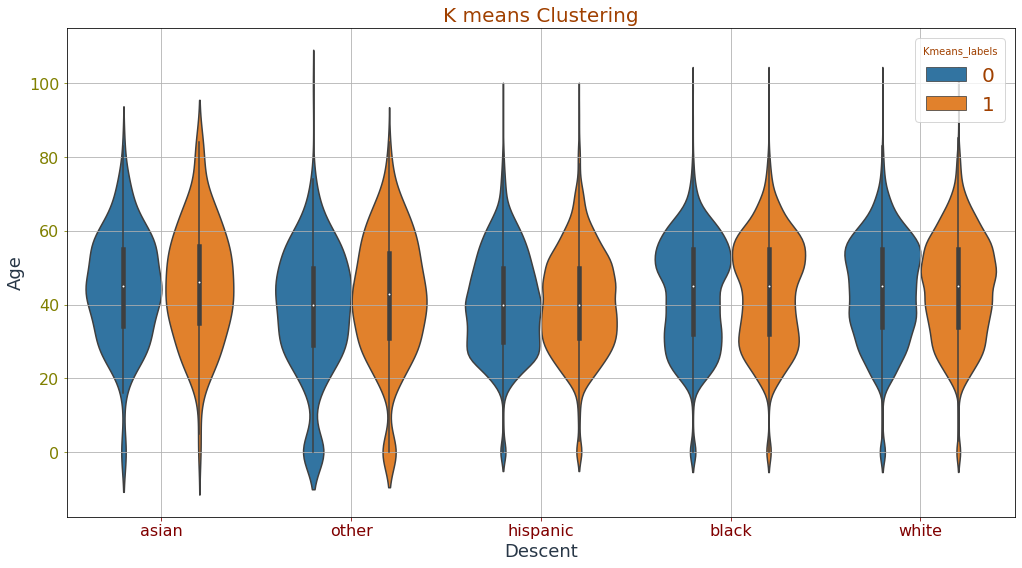

In [79]:
plt.figure(figsize = (17,9))


sns.violinplot(x='victim_descent',y='victim_age',hue = 'Kmeans_labels',data= clusteringDF)



plt.xlabel('Descent')
plt.ylabel('Age')
plt.title('K means Clustering', fontsize = 20);

plt.grid();
plt.show();

####  PAM: Age vs Sex

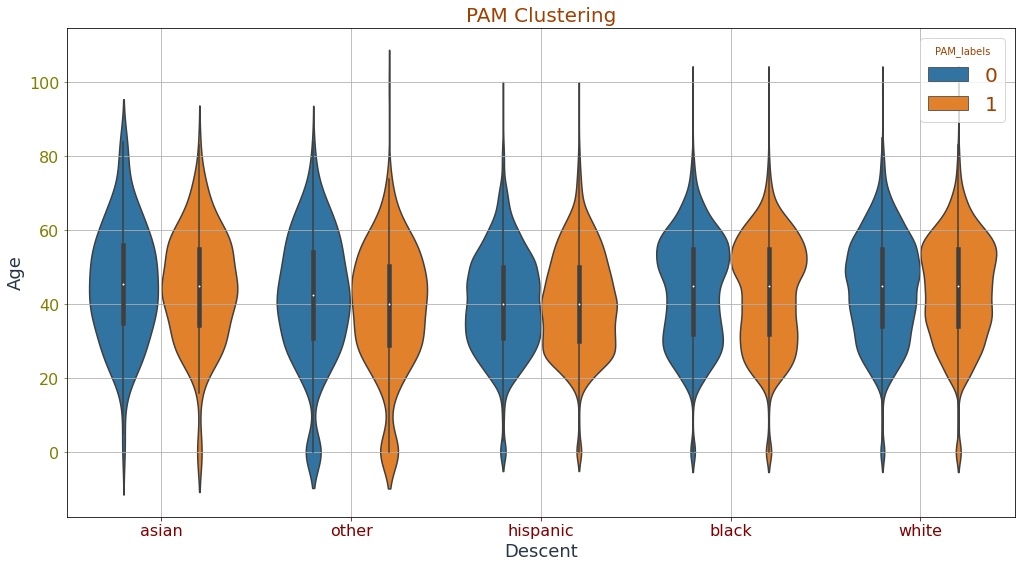

In [80]:
plt.figure(figsize = (17,9))


sns.violinplot(x='victim_descent',y='victim_age',hue = 'PAM_labels',data= clusteringDF)

plt.xlabel('Descent')
plt.ylabel('Age')
plt.title('PAM Clustering', fontsize = 20);

plt.grid();
plt.show();

### 4.1.5 Clusters Results

#### K Means

In [83]:
col = "Kmeans_labels"
cluster1 = clusteringDF[clusteringDF[col] == 0]
cluster2 = clusteringDF[clusteringDF[col] == 1]

print("CLUSTER 1")

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + "Male Victims in Cluster 1 - ", cluster1['victim_sex_male'].sum())
print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + "Female Victims in Cluster 1 - ", cluster1['victim_sex_female'].sum())
print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + "\n")
print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Distribution of Victims by Age Group in cluster 1')
pd.DataFrame(cluster1.AgeGroup.value_counts())

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Crimes by Category in cluster 1')
pd.DataFrame(cluster1.crime_code_description.value_counts().nlargest(5))

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Premises where Crimes occured in cluster 1')
pd.DataFrame(cluster1.premises_description.value_counts().nlargest(5))

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Weapons which where used in Crimes in cluster 1')
pd.DataFrame(cluster1.weapon_description.value_counts().nlargest(5))

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Distribution of Victims by Race/Community in cluster 1')
pd.DataFrame(cluster1.descent_description.value_counts())

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Division by Crimes Occurence in cluster 1')
pd.DataFrame(cluster1.division_name.value_counts().nlargest(5))

print("CLUSTER 2")

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + "Male Victims in Cluster 2 - ", cluster2['victim_sex_male'].sum())
print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + "Female Victims in Cluster 2 - ", cluster2['victim_sex_female'].sum())
print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + "\n")
print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Distribution of Victims by Age Group in Cluster 2')
pd.DataFrame(cluster2.AgeGroup.value_counts())

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Crimes by Category in Cluster 2')
pd.DataFrame(cluster2.crime_code_description.value_counts().nlargest(5))

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Premises where Crimes occured in Cluster 2')
pd.DataFrame(cluster2.premises_description.value_counts().nlargest(5))

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Weapons which where used in Crimes in Cluster 2')
pd.DataFrame(cluster2.weapon_description.value_counts().nlargest(5))

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Distribution of Victims by Race/Community in Cluster 2')
pd.DataFrame(cluster2.descent_description.value_counts())

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Division by Crimes Occurence in Cluster 2')
pd.DataFrame(cluster2.division_name.value_counts().nlargest(5))

CLUSTER 1
Male Victims in Cluster 1 -  7975
Female Victims in Cluster 1 -  5239


Distribution of Victims by Age Group in cluster 1


AgeGroup
Adult        8254
Elder        4543
Teen          199
Kid            27
Toddler         8

Top 5 Crimes by Category in cluster 1


crime_code_description
Assault with deadly weapon, aggravated assault                    3811
Battery - simple assault                                          2537
Robbery                                                           1527
Intimate partner - simple assault                                 1313
Theft plain - petty ($950 & under)                                 888

Top 5 Premises where Crimes occured in cluster 1


premises_description
Sidewalk                                                      4222
Street                                                        3794
Parking lot                                                    758
Multi-unit dwelling (apartment, duplex, etc)                   592
Park/playground                                                504

Top 5 Weapons which where used in Crimes in cluster 1


weapon_description
Strong-arm (hands, fist, feet or bodily force)                5529
Unknown weapon/other weapon                                   1184
Other knife                                                    527
Hand gun                                                       435
Knife with blade 6inches or less                               426

Distribution of Victims by Race/Community in cluster 1


descent_description
black                    4731
hispanic                 4235
white                    3653
other                     444
asian                     150

Top 5 Division by Crimes Occurence in cluster 1


division_name
Central             4234
Rampart              967
Newton               833
Pacific              769
Hollywood            617

CLUSTER 2
Male Victims in Cluster 2 -  7959
Female Victims in Cluster 2 -  5987


Distribution of Victims by Age Group in Cluster 2


AgeGroup
Adult        8595
Elder        4919
Teen          238
Kid            30
Toddler        14

Top 5 Crimes by Category in Cluster 2


crime_code_description
Assault with deadly weapon, aggravated assault                    3255
Battery - simple assault                                          2391
Theft plain - petty ($950 & under)                                1650
Robbery                                                           1471
Intimate partner - simple assault                                 1268

Top 5 Premises where Crimes occured in Cluster 2


premises_description
Sidewalk                                                      4015
Street                                                        3783
Parking lot                                                    770
Multi-unit dwelling (apartment, duplex, etc)                   744
Park/playground                                                566

Top 5 Weapons which where used in Crimes in Cluster 2


weapon_description
Strong-arm (hands, fist, feet or bodily force)                5874
Unknown weapon/other weapon                                   1148
Other knife                                                    406
Knife with blade 6inches or less                               356
Hand gun                                                       337

Distribution of Victims by Race/Community in Cluster 2


descent_description
black                    4900
hispanic                 4319
white                    4009
other                     565
asian                     153

Top 5 Division by Crimes Occurence in Cluster 2


division_name
Central             4424
Rampart             1042
Newton               846
Pacific              738
Hollywood            659

#### PAM

In [84]:
col = "PAM_labels"
cluster1 = clusteringDF[clusteringDF[col] == 0]
cluster2 = clusteringDF[clusteringDF[col] == 1]

print("CLUSTER 1")

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + "Male Victims in Cluster 1 - ", cluster1['victim_sex_male'].sum())
print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + "Female Victims in Cluster 1 - ", cluster1['victim_sex_female'].sum())
print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + "\n")
print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Distribution of Victims by Age Group in cluster 1')
pd.DataFrame(cluster1.AgeGroup.value_counts())

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Crimes by Category in cluster 1')
pd.DataFrame(cluster1.crime_code_description.value_counts().nlargest(5))

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Premises where Crimes occured in cluster 1')
pd.DataFrame(cluster1.premises_description.value_counts().nlargest(5))

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Weapons which where used in Crimes in cluster 1')
pd.DataFrame(cluster1.weapon_description.value_counts().nlargest(5))

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Distribution of Victims by Race/Community in cluster 1')
pd.DataFrame(cluster1.descent_description.value_counts())

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Division by Crimes Occurence in cluster 1')
pd.DataFrame(cluster1.division_name.value_counts().nlargest(5))

print("CLUSTER 2")

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + "Male Victims in Cluster 2 - ", cluster2['victim_sex_male'].sum())
print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + "Female Victims in Cluster 2 - ", cluster2['victim_sex_female'].sum())
print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + "\n")
print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Distribution of Victims by Age Group in Cluster 2')
pd.DataFrame(cluster2.AgeGroup.value_counts())

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Crimes by Category in Cluster 2')
pd.DataFrame(cluster2.crime_code_description.value_counts().nlargest(5))

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Premises where Crimes occured in Cluster 2')
pd.DataFrame(cluster2.premises_description.value_counts().nlargest(5))

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Weapons which where used in Crimes in Cluster 2')
pd.DataFrame(cluster2.weapon_description.value_counts().nlargest(5))

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Distribution of Victims by Race/Community in Cluster 2')
pd.DataFrame(cluster2.descent_description.value_counts())

print(color.BOLD  + color.UNDERLINE + color.DARKCYAN + 'Top 5 Division by Crimes Occurence in Cluster 2')
pd.DataFrame(cluster2.division_name.value_counts().nlargest(5))

CLUSTER 1
Male Victims in Cluster 1 -  7939
Female Victims in Cluster 1 -  5974


Distribution of Victims by Age Group in cluster 1


AgeGroup
Adult        8576
Elder        4892
Teen          239
Kid            30
Toddler        14

Top 5 Crimes by Category in cluster 1


crime_code_description
Assault with deadly weapon, aggravated assault                    3248
Battery - simple assault                                          2384
Theft plain - petty ($950 & under)                                1646
Robbery                                                           1469
Intimate partner - simple assault                                 1262

Top 5 Premises where Crimes occured in cluster 1


premises_description
Sidewalk                                                      4015
Street                                                        3767
Parking lot                                                    766
Multi-unit dwelling (apartment, duplex, etc)                   744
Park/playground                                                565

Top 5 Weapons which where used in Crimes in cluster 1


weapon_description
Strong-arm (hands, fist, feet or bodily force)                5857
Unknown weapon/other weapon                                   1144
Other knife                                                    406
Knife with blade 6inches or less                               356
Hand gun                                                       337

Distribution of Victims by Race/Community in cluster 1


descent_description
black                    4888
hispanic                 4312
white                    3991
other                     570
asian                     152

Top 5 Division by Crimes Occurence in cluster 1


division_name
Central             4417
Rampart             1041
Newton               844
Pacific              734
Hollywood            659

CLUSTER 2
Male Victims in Cluster 2 -  7995
Female Victims in Cluster 2 -  5252


Distribution of Victims by Age Group in Cluster 2


AgeGroup
Adult        8273
Elder        4570
Teen          198
Kid            27
Toddler         8

Top 5 Crimes by Category in Cluster 2


crime_code_description
Assault with deadly weapon, aggravated assault                    3818
Battery - simple assault                                          2544
Robbery                                                           1529
Intimate partner - simple assault                                 1319
Theft plain - petty ($950 & under)                                 892

Top 5 Premises where Crimes occured in Cluster 2


premises_description
Sidewalk                                                      4222
Street                                                        3810
Parking lot                                                    762
Multi-unit dwelling (apartment, duplex, etc)                   592
Park/playground                                                505

Top 5 Weapons which where used in Crimes in Cluster 2


weapon_description
Strong-arm (hands, fist, feet or bodily force)                5546
Unknown weapon/other weapon                                   1188
Other knife                                                    527
Hand gun                                                       435
Knife with blade 6inches or less                               426

Distribution of Victims by Race/Community in Cluster 2


descent_description
black                    4743
hispanic                 4242
white                    3671
other                     439
asian                     151

Top 5 Division by Crimes Occurence in Cluster 2


division_name
Central             4241
Rampart              968
Newton               835
Pacific              773
Hollywood            617

### 4.1.6 Cluster Wordclouds

In [85]:
import re, string, unicodedata
import nltk
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

class Preprocess_Text():
    
    def __init__(self, text = "test"):
        self.text = text
        
    def strip_html(self):
        soup = BeautifulSoup(self.text, "html.parser")
        self.text = soup.get_text()
        return self

    def remove_between_square_brackets(self):
        self.text = re.sub('\[[^]]*\]', '', self.text)
        return self

    def remove_numbers(self):
        self.text = re.sub('[-+]?[0-9]+', '', self.text)
        return self

    def get_words(self):
        self.words = nltk.word_tokenize(self.text)
        return self

    def remove_non_ascii(self):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in self.words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        self.words = new_words
        return self

    def to_lowercase(self):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in self.words:
            new_word = word.lower()
            new_words.append(new_word)
        self.words = new_words
        return self

    def remove_punctuation(self):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in self.words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        self.words = new_words
        return self

    def replace_numbers(self):
        """Replace all interger occurrences in list of tokenized words with textual representation"""
        p = inflect.engine()
        new_words = []
        for word in self.words:
            if word.isdigit():
                new_word = p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        self.words = new_words
        return self

    def remove_stopwords(self):
        """Remove stop words from list of tokenized words"""
        new_words = []
        for word in self.words:
            if word not in stopwords.words('english'):
                new_words.append(word)
        self.words = new_words
        return self


    
    def join_words(self):
        self.words = ' '.join(self.words)
        return self
    
    def clean_text(self, text):
        
        self.text = text
        self = self.strip_html()
        self = self.remove_numbers()
        self = self.get_words()
        self = self.remove_punctuation()
        self = self.remove_non_ascii()
        self = self.remove_stopwords()
        self = self.join_words()
        
        return self.words
    
clusteringDF['all_descriptions'] = clusteringDF["crime_code_description"] + ' ' + clusteringDF["premises_description"] + ' '  + clusteringDF["descent_description"] + ' ' + clusteringDF["division_name"] + ' ' + clusteringDF["address"]
clusteringDF['all_descriptions'] = clusteringDF['all_descriptions'].astype(str)

ct = Preprocess_Text()
clusteringDF['cleaned_all_descriptions'] = clusteringDF['all_descriptions'].apply(ct.clean_text)

#### K Means

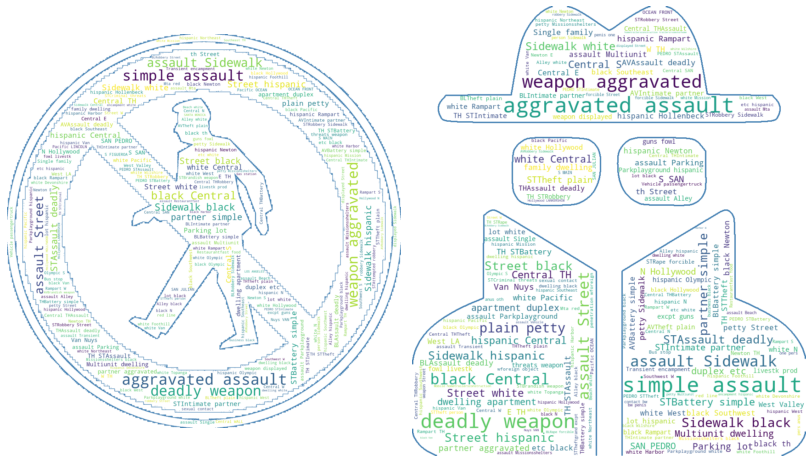

In [86]:
col = "Kmeans_labels"
cluster1 = clusteringDF[clusteringDF[col] == 0]
cluster2 = clusteringDF[clusteringDF[col] == 1]

text_cluster1 = ""
text_cluster1 = ''.join(cluster1['cleaned_all_descriptions'])


text_cluster2 = ""
text_cluster2 = ''.join(cluster2['cleaned_all_descriptions'])

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


fig = plt.figure(figsize=(17,9))

ax = fig.add_subplot(1, 3, 1)
custom_mask = np.array(Image.open("prohibition3.png"))
wc = WordCloud(background_color="white", mask=custom_mask, contour_width=3, contour_color='steelblue', max_words=200)
wc.generate(text_cluster1)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
# Creating color map
my_cmap = plt.get_cmap('jet')

 
ax = fig.add_subplot(1, 3, 2)
custom_mask = np.array(Image.open("robbery.png"))
wc = WordCloud(background_color="white", mask=custom_mask, contour_width=3, contour_color='steelblue' , max_words=200)
wc.generate(text_cluster2)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")


plt.tight_layout()
plt.show();

#### PAM

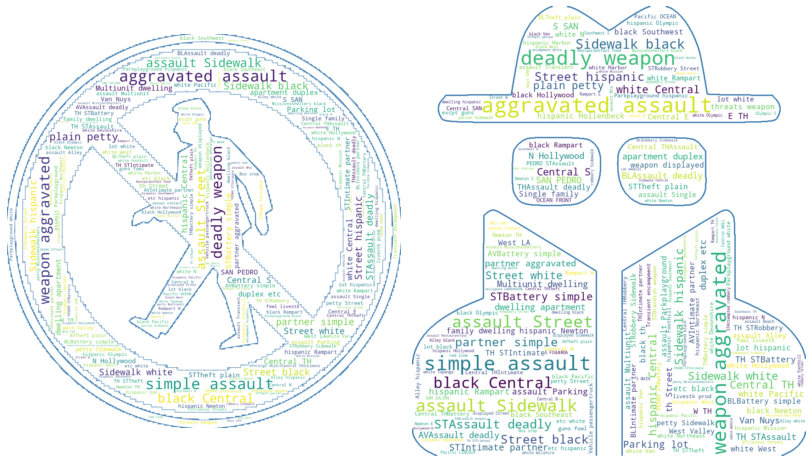

In [87]:
col = "PAM_labels"
cluster1 = clusteringDF[clusteringDF[col] == 0]
cluster2 = clusteringDF[clusteringDF[col] == 1]

text_cluster1 = ""
text_cluster1 = ''.join(cluster1['cleaned_all_descriptions'])


text_cluster2 = ""
text_cluster2 = ''.join(cluster2['cleaned_all_descriptions'])

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image


fig = plt.figure(figsize=(17,9))

ax = fig.add_subplot(1, 3, 1)
custom_mask = np.array(Image.open("prohibition3.png"))
wc = WordCloud(background_color="white", mask=custom_mask, contour_width=3, contour_color='steelblue', max_words=200)
wc.generate(text_cluster1)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
 
# Creating color map
my_cmap = plt.get_cmap('jet')

 
ax = fig.add_subplot(1, 3, 2)
custom_mask = np.array(Image.open("robbery.png"))
wc = WordCloud(background_color="white", mask=custom_mask, contour_width=3, contour_color='steelblue' , max_words=200)
wc.generate(text_cluster2)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")


plt.tight_layout()
plt.show();

## 4.2. ARIMA & LSTM Forecasting

### 4.2.1 ARIMA Model

<Figure size 864x576 with 0 Axes>

victim_sex male


Text(0.5, 1.0, 'ARIMA Number of cases based on victim_sex,2010-2022')

victim_sex female


Text(0.5, 1.0, 'ARIMA Number of cases based on victim_sex,2010-2022')

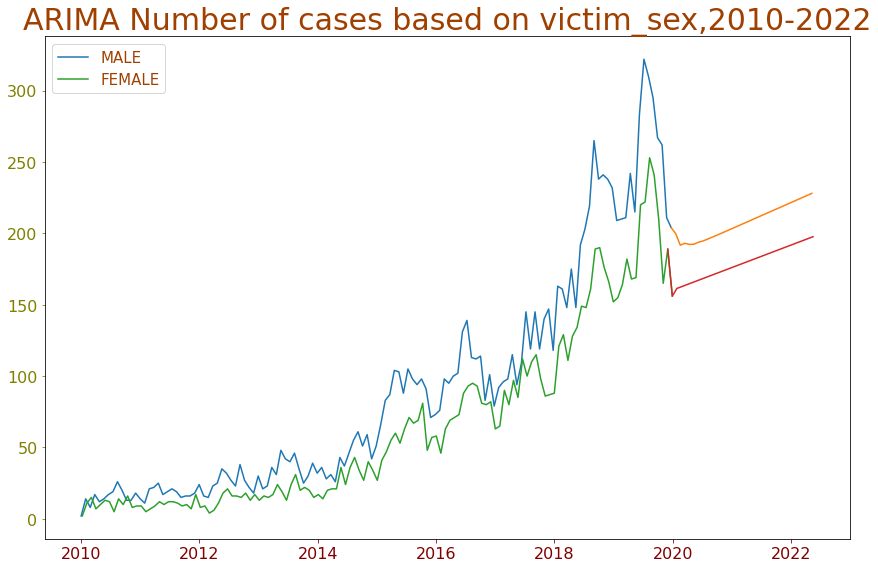

<Figure size 864x576 with 0 Axes>

victim_descent asian


Text(0.5, 1.0, 'ARIMA Number of cases based on victim_descent,2010-2022')

victim_descent other


Text(0.5, 1.0, 'ARIMA Number of cases based on victim_descent,2010-2022')

victim_descent hispanic


Text(0.5, 1.0, 'ARIMA Number of cases based on victim_descent,2010-2022')

victim_descent black


Text(0.5, 1.0, 'ARIMA Number of cases based on victim_descent,2010-2022')

victim_descent white


Text(0.5, 1.0, 'ARIMA Number of cases based on victim_descent,2010-2022')

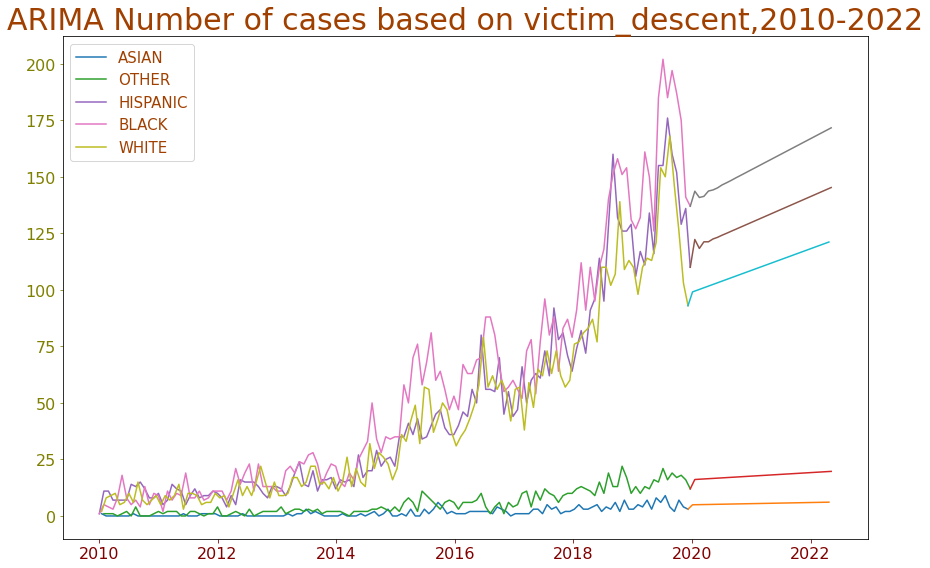

<Figure size 864x576 with 0 Axes>

AgeGroup Adult


Text(0.5, 1.0, 'ARIMA Number of cases based on AgeGroup,2010-2022')

AgeGroup Toddler


Text(0.5, 1.0, 'ARIMA Number of cases based on AgeGroup,2010-2022')

AgeGroup Elder


Text(0.5, 1.0, 'ARIMA Number of cases based on AgeGroup,2010-2022')

AgeGroup Teen


Text(0.5, 1.0, 'ARIMA Number of cases based on AgeGroup,2010-2022')

AgeGroup Kid


Text(0.5, 1.0, 'ARIMA Number of cases based on AgeGroup,2010-2022')

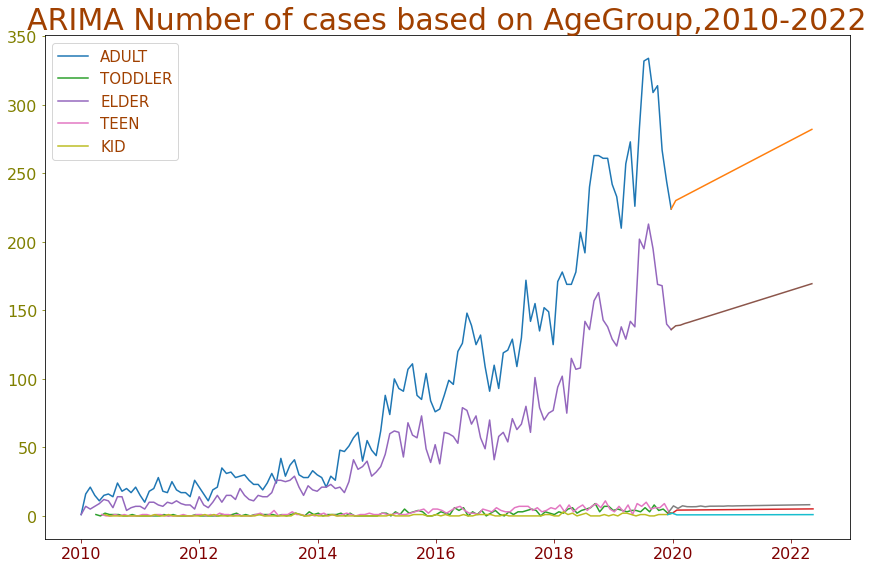

<Figure size 864x576 with 0 Axes>

crime_code_description Assault with deadly weapon, aggravated assault


Text(0.5, 1.0, 'ARIMA Number of cases based on crime_code_description,2010-2022')

crime_code_description Battery - simple assault


Text(0.5, 1.0, 'ARIMA Number of cases based on crime_code_description,2010-2022')

crime_code_description Robbery


Text(0.5, 1.0, 'ARIMA Number of cases based on crime_code_description,2010-2022')

crime_code_description Intimate partner - simple assault


Text(0.5, 1.0, 'ARIMA Number of cases based on crime_code_description,2010-2022')

crime_code_description Theft plain - petty ($950 & under)


Text(0.5, 1.0, 'ARIMA Number of cases based on crime_code_description,2010-2022')

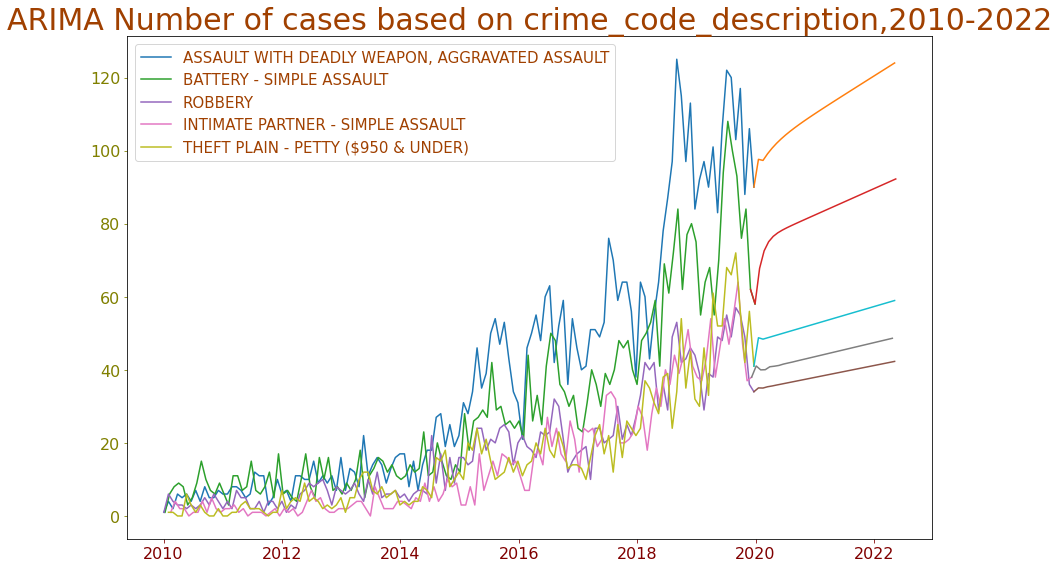

<Figure size 864x576 with 0 Axes>

division_name Central


Text(0.5, 1.0, 'ARIMA Number of cases based on division_name,2010-2022')

division_name Rampart


Text(0.5, 1.0, 'ARIMA Number of cases based on division_name,2010-2022')

division_name Newton


Text(0.5, 1.0, 'ARIMA Number of cases based on division_name,2010-2022')

division_name Pacific


Text(0.5, 1.0, 'ARIMA Number of cases based on division_name,2010-2022')

division_name Hollywood


Text(0.5, 1.0, 'ARIMA Number of cases based on division_name,2010-2022')

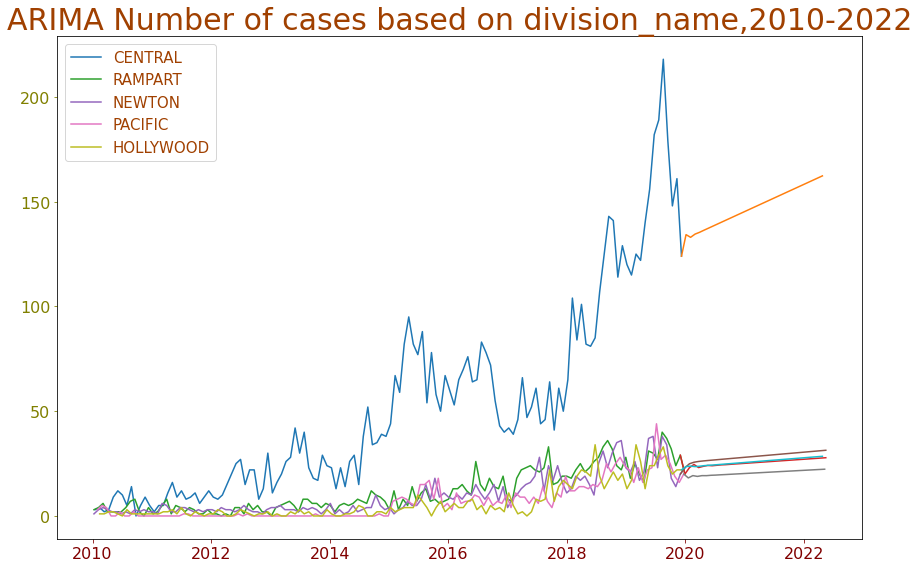

In [25]:
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings 
warnings.filterwarnings('ignore')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

arima_dict = dict()

for key,values in list ( values_dict.items() )[:]:
    
    plt.figure(figsize = (12,8));
    
    color_counter = 0
    
    for value in values[:]:
        
        print(key, value)
        
        time_series_df_dummy = df.copy()
                
        time_series_df_dummy = time_series_df_dummy[['date_occurred',key]]
                
        time_series_df_dummy = time_series_df_dummy[time_series_df_dummy[key] == value]
        
        time_series_df_dummy.set_index('date_occurred',inplace = True)
        
                
        time_series_df_dummy = time_series_df_dummy[[key]].resample(rule = '4w').count()
        
        time_series_df_dummy.rename(columns = {key : 'NUM CASES'}, inplace = True)
                
        stepwise_fit = auto_arima(y = time_series_df_dummy["NUM CASES"], x = time_series_df_dummy.index, start_p= 0,
                                  start_q = 0, seasonal=False)
        
        p = int ( str(stepwise_fit)[7] ) 
        d = int ( str(stepwise_fit)[9] )
        q = int ( str(stepwise_fit)[11] )
        
        
        arima_dict[(key,value)] = (p,d,q)
        
        time_series_df_dummy = time_series_df_dummy.loc[:'2019-12-31']
        
        model = ARIMA(time_series_df_dummy['NUM CASES'],order= (p,d,q))
        result = model.fit()
        fcast = result.predict(start = len(time_series_df_dummy),end = len(time_series_df_dummy)+6*5,typ='levels')
        
        fcast_df = pd.DataFrame(fcast)
        fcast_df.rename(columns = {0: 'NUM CASES'}, inplace = True)
        fcast_df.index.name = 'date_occurred'
        
        full = pd.concat([time_series_df_dummy,fcast_df])
        
        full_train = full.loc[:'2019-12-31']
        full_test = full['2019-11-30':]
        
        plt.plot(full_train.index, full_train['NUM CASES'], color=colors[color_counter], label = value.upper());
        plt.plot(full_test.index, full_test['NUM CASES'], color=colors[color_counter+1]);
        plt.title("ARIMA Number of cases based on "+key+",2010-2022");

        plt.legend(loc = 'upper left',prop={'size': 15});

        plt.tight_layout();
        
        color_counter += 2
        
    plt.show();  

### 4.2.2. LSTM Model

#### 4.2.2.1 LSTM Predictions

**NOTE:** Every run will give you different predictions for LSTM as each run the data will be split into train and test with different cross validation dataset from this following line                                
`history = regressor.fit(X_train, y_train, validation_split=0.30, epochs = 10, batch_size = 12)`

<Figure size 1152x576 with 0 Axes>

victim_descent asian
Epoch 1/10
8/8 [==============================] - 7s 349ms/step - loss: 0.0173 - val_loss: 0.1592
Epoch 2/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0205 - val_loss: 0.1298
Epoch 3/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0192 - val_loss: 0.1350
Epoch 4/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0168 - val_loss: 0.1485
Epoch 5/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0141 - val_loss: 0.1370
Epoch 6/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0226 - val_loss: 0.1134
Epoch 7/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0145 - val_loss: 0.1215
Epoch 8/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0179 - val_loss: 0.0956
Epoch 9/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0103 - val_loss: 0.0839
Epoch 10/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0104 - val_loss: 0.0611


Text(0.5, 1.0, 'LSTM Number of cases based on victim_descent,2010-2022')

victim_descent other
Epoch 1/10
8/8 [==============================] - 6s 169ms/step - loss: 0.0295 - val_loss: 0.2772
Epoch 2/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0171 - val_loss: 0.2015
Epoch 3/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0107 - val_loss: 0.2082
Epoch 4/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0113 - val_loss: 0.2231
Epoch 5/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0133 - val_loss: 0.2091
Epoch 6/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0131 - val_loss: 0.1935
Epoch 7/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0146 - val_loss: 0.1804
Epoch 8/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0087 - val_loss: 0.1655
Epoch 9/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0103 - val_loss: 0.0894
Epoch 10/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0096 - val_loss: 0.0923


Text(0.5, 1.0, 'LSTM Number of cases based on victim_descent,2010-2022')

victim_descent hispanic
Epoch 1/10
8/8 [==============================] - 7s 245ms/step - loss: 0.0227 - val_loss: 0.3097
Epoch 2/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0134 - val_loss: 0.2193
Epoch 3/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0103 - val_loss: 0.2153
Epoch 4/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0080 - val_loss: 0.2366
Epoch 5/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0079 - val_loss: 0.2259
Epoch 6/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0078 - val_loss: 0.1895
Epoch 7/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.1349
Epoch 8/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0060 - val_loss: 0.0748
Epoch 9/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0035 - val_loss: 0.0304
Epoch 10/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0347


Text(0.5, 1.0, 'LSTM Number of cases based on victim_descent,2010-2022')

victim_descent black
Epoch 1/10
8/8 [==============================] - 7s 167ms/step - loss: 0.0340 - val_loss: 0.3135
Epoch 2/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0223 - val_loss: 0.2143
Epoch 3/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0151 - val_loss: 0.1866
Epoch 4/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0133 - val_loss: 0.2132
Epoch 5/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0149 - val_loss: 0.2000
Epoch 6/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0108 - val_loss: 0.1471
Epoch 7/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0086 - val_loss: 0.0599
Epoch 8/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 0.0168
Epoch 9/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0031 - val_loss: 0.0466
Epoch 10/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0158


Text(0.5, 1.0, 'LSTM Number of cases based on victim_descent,2010-2022')

victim_descent white
Epoch 1/10
8/8 [==============================] - 7s 158ms/step - loss: 0.0170 - val_loss: 0.2608
Epoch 2/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0090 - val_loss: 0.1784
Epoch 3/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0119 - val_loss: 0.1821
Epoch 4/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0104 - val_loss: 0.2118
Epoch 5/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0098 - val_loss: 0.1857
Epoch 6/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0096 - val_loss: 0.1496
Epoch 7/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0975
Epoch 8/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0054 - val_loss: 0.0268
Epoch 9/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0247
Epoch 10/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0039 - val_loss: 0.0164


Text(0.5, 1.0, 'LSTM Number of cases based on victim_descent,2010-2022')

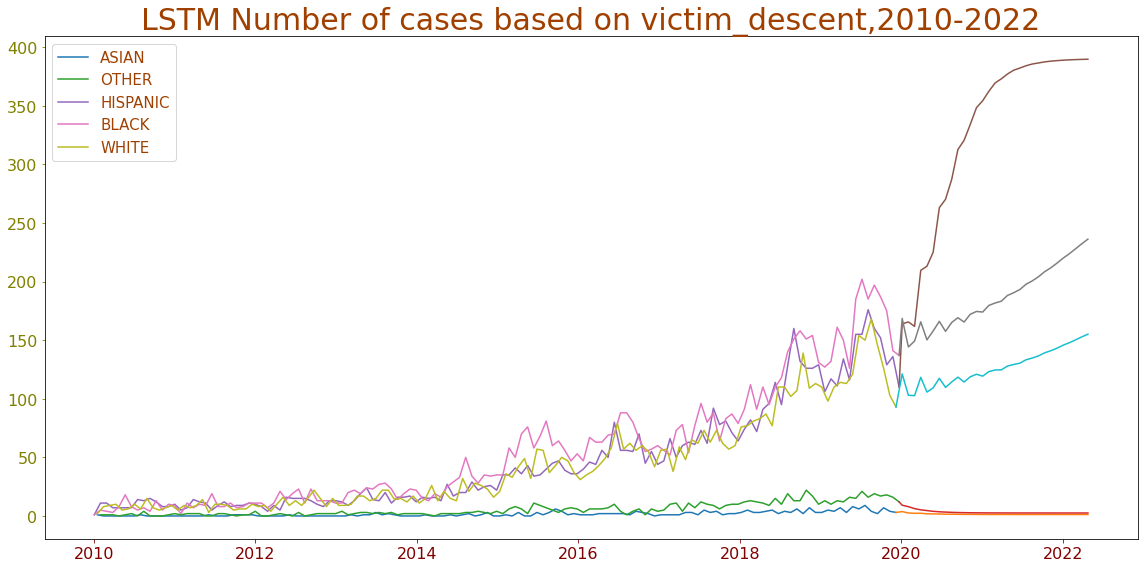

In [26]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import warnings 
warnings.filterwarnings('ignore')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

batch_size = 3

for key,values in list ( values_dict.items() )[:]:

    
    plt.figure(figsize = (16,8));

    color_counter = 0

    for value in values[:]:

        print(key, value)


        fcast_df = pd.read_csv("fcast_df.csv",index_col=0)

        fcast_df.index = pd.to_datetime(fcast_df.index)

        time_series_df_dummy = df.copy()

        time_series_df_dummy = time_series_df_dummy[['date_occurred',key]]

        time_series_df_dummy = time_series_df_dummy[time_series_df_dummy[key] == value]

        time_series_df_dummy.set_index('date_occurred',inplace = True)

        time_series_df_dummy = time_series_df_dummy[[key]].resample(rule = '4w').count()

        time_series_df_dummy.rename(columns = {key : 'NUM CASES'}, inplace = True)

        time_series_df_dummy = time_series_df_dummy.loc[:'2019-12-31']


        training_set = time_series_df_dummy['NUM CASES'].values.reshape(-1,1)
        sc = MinMaxScaler(feature_range = (0, 1))
        training_set_scaled = sc.fit_transform(training_set)

        batch_size = batch_size * 1

        X_train = []
        y_train = []
        for i in range(batch_size, len(training_set)):
            X_train.append(training_set_scaled[i-batch_size:i, 0])
            y_train.append(training_set_scaled[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)

        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))



        regressor = Sequential()

        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units = 50, return_sequences = True))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units = 50, return_sequences = True))
        regressor.add(Dropout(0.2))

        regressor.add(LSTM(units = 50))
        regressor.add(Dropout(0.2))

        regressor.add(Dense(units = 1))

        regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

        history = regressor.fit(X_train, y_train, validation_split=0.30, epochs = 10, batch_size = 12)

        inputs = time_series_df_dummy.values
        inputs = inputs.reshape(-1,1)
        inputs = sc.transform(inputs)

        for i in range(len(fcast_df)):
            X_test = inputs[-batch_size:]
            X_test = np.reshape(X_test, (1,batch_size, 1))
            predicted_crimes = regressor.predict(X_test)
            inputs = np.append(inputs,predicted_crimes);
        inputs = inputs.reshape(-1, 1)
        predicted_crimes = sc.inverse_transform(inputs)
        predicted_crimes = predicted_crimes.tolist()

        full = pd.concat([time_series_df_dummy,fcast_df])
        full['NUM CASES'] = np.squeeze(predicted_crimes)


        fcast = []
        for x in predicted_crimes:
            fcast.append(x[0])

        full_train = full.loc[:'2019-12-31']
        full_test = full['2019-11-30':]

        plt.plot(full_train.index, full_train['NUM CASES'], color=colors[color_counter],label = value.upper());
        plt.plot(full_test.index, full_test['NUM CASES'], color=colors[color_counter+1]);
        plt.title("LSTM Number of cases based on "+key+",2010-2022");
        plt.legend(loc = 'upper left',prop={'size': 15})
        plt.tight_layout();

        color_counter += 2

    plt.show();

#### 4.2.2.2 LSTM Artifacts 

Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

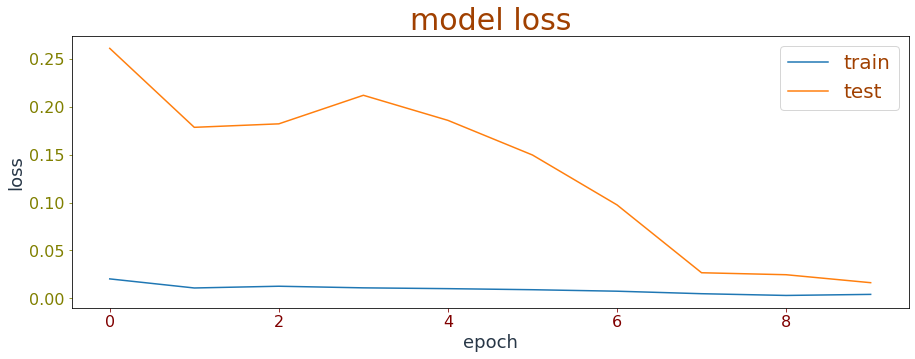

In [30]:
plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])

plt.title('model loss')

plt.ylabel('loss')

plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper right')

plt.show()